In [1]:
import numpyro
numpyro.set_host_device_count(4)
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import warnings
warnings.filterwarnings('ignore', message='The RandomType SharedVariables')
warnings.filterwarnings('ignore', message='Skipping `CheckAndRaise` Op')

plt.rcParams.update({
    'figure.figsize': (14, 4),
    'figure.dpi': 144,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.linestyle': '--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False,
    'figure.constrained_layout.use': True
})

import numpy as np
seed = sum(map(ord, 'LEGO as a Modeling Philosophy'))
rng = np.random.default_rng()

# Custom Statespace Models

For the last example, we're going all out with quite an advanced use-case.

In 1976, Economics Nobel Lauriate Robert Lucas put forward the "Lucas Critique" of macroeconomic models. Basically, he said that policy advice based on econometric models was invalid unless the model was build on "micro foundations". To oversimply, he suggested we should write bottom-up strutural models that start from individual choices rather than top-down models of macroeconomic variables like VARs.

The Lucas Criquite kicked off a research agenda into micro-founded models that continues to this day. One major branch of that agenda are DSGE models: Dynamic Stochastic General Equlibrium models. The simplest such model, the Real Business Cycle (RBC) model, will be the subject of this notebook. 

We will use the RBC to see how even complex non-linear models with non-gaussian shocks can be cast into the Linear Gaussian Statespace framework. We will also see how to set up and estimate a custom statespace model using the tools in `pymc_experimental.statespace`.

# RBC Model

The RBC model starts with a household that seeks to maximize expected lifetme flow of utility by 1) consuming, and 2) not working. The household earns money by supplying labor and capital to the firm, and buys consumption and investment goods. The firm manufactures a single composite good which can be either consumed or invested. This good is produced by combining labor and capital.

## Household Problem

Define $C_t$ as units of goods consumed in period $t$, and $L_t$ as hours worked in period $t$. Total lifetime utility starting from today is then:

$$
U_t = \mathbb E_t \left [ \sum_{s=0}^\infty \beta^s u(C_{t+s}, L_{t+s}) \right ] \tag{1}
$$

Where $u$ is a utility function that measure how good today is. A common utility function is the CRRA function: $u(C_t, L_t) = \frac{C_t ^ {1 - \sigma_c}}{1 - \sigma_c} - \Theta \frac{L_t ^ {1 + \sigma_L}}{1 + \sigma_L}$

The agent earns income by working at hourly wage $w_t$, so total wage income in period $t$ is $L_t w_t$. He also owns investment capital (think machines), which he rents to firms for an hourly fee $r_t$. Capital income is thus $K_{t-1} r_t$. Finally, he is also the shareholder of the firm, so he gets dividends $\Pi_t$. 

He uses this income to buy consumption goods $C_t$, and to invest in more machines to rent later, $I_t$. 

The optimization show in (1) is thus subject to the following resource constraint:

$$
P_t (C_t + I_t) = r_t K_{t-1} + w_t L_t + \Pi_t
$$

Finally, an equation to connect investment to the total stock of machines avaiable to rent out:

$$
K_t = I_t + (1 - \delta) K_{t-1}
$$

So the problem is:

$$
\max_{C_t, L_t, I_t, K_t} \mathbb E_t \left [ \sum_{s=0}^\infty \beta^s \left ( \frac{C_{t+s} ^ {1 - \sigma_c}}{1 - \sigma_c} - \Theta \frac{L_{t+s} ^ {1 + \sigma_L}}{1 + \sigma_L} \right ) \right ], \quad s.t. \begin{cases} P_{t+s} (C_{t+s} + I_{t+s}) = r_{t+s} K_{t+s-1} + w_{t+s} L_{t+s} + \Pi_{t+s} \\ K_{t+s} = I_{t+s} + (1 - \delta) K_{t+s-1} \end{cases}
$$


To solve this, first solve the 2nd constraint for $I_t$, and eliminate $I_t$ as a control variable by substitution:

$$
\max_{C_t, L_t, K_t} \begin{align} & \mathbb E_t \left [ \sum_{s=0}^\infty \beta^s \left ( \frac{C_{t+s} ^ {1 - \sigma_c}}{1 - \sigma_c} - \Theta \frac{L_{t+s} ^ {1 + \sigma_L}}{1 + \sigma_L} \right ) \right ], \quad s.t. \\ 
& P_{t+s} (C_{t+s} + K_{t+s} - (1 - \delta) K_{t+s-1}) = r_{t+s} K_{t+s-1} + w_{t+s} L_{t+s} + \Pi_{t+s} \end{align}
$$

This problem can now be solved by setting up a Lagrangian and finding first order conditions. Introduce lagrangian multipler $\lambda_{t+s}$ on each constraint, and take derivatives. The solution will be:

$$
\begin{align}
C_t^{\sigma_C}L_t^{\sigma_L} &= \frac{w_t}{\Theta P_t}\\
\lambda_t &= \frac{C_t^{-\sigma_C}}{P_t} \\
C_t^{-\sigma_C} &= \beta \mathbb E_t [C_{t+1}^{-\sigma_C} ((1 - \delta) + \frac{r_{t+1}}{P_{t+1}} ) ]\\
\end{align}
$$

## Firm Problem

The firm solves a relatively simpler static profit maximization problem. Here I state it as a cost minimization problem, which is equivalent:

$$\min_{K_{t-1}, L_t} r_t K_{t-1} + w_t L_{t-1}, \quad s.t. Y_t = A_t K_{t-1}^\alpha L_t^{1 - \alpha}$$

Introduce Lagrange multiplier $\mu_t$ and solve for first order conditions:

$$\begin{align}
K_{t-1} &= \alpha \mu_t \frac{Y_t}{r_t} \\
L_t &= (1 - \alpha) \mu_t \frac{Y_t}{w_t}
\end{align}
$$

## Technology Process

The variable $A_t$ is a random variable that describes changes in "technology" that either speed up or slow down production. Shocks should:

1. Be strictly positive, because GDP (output) can never be negative
2. Be autocorrelated, because technology doesn't just vanish (although the relative advantage it grants a firm might fade as it becomes widely adopted).

We can't do this in a Linear Guassian setup, because shocks have to be, well, linear and gaussian.

We will instead introduce an auxillary state variable that will be AR(1) in logs:

$$
\ln A_t = \rho \ln A_{t-1} + \epsilon_t
$$

Which is legal in our setup.

## Market Clearing

To close the model, we note that:

1) The firm is in perfect competition, so price is equal to marginal cost and dividends are zero. The firm lagrange multiplier is, by definition, marginal cost, so $\mu_t = P_t$ and $\Pi_t = 0$.
2) By Walras' Law, we have one extra degree of freedom in the price vector -- we have to write all prices in the model as *relative* to a numeraire price. We choose $P_t$ as the numeraire, so $P_t = 1$ and $r_t, w_t$ are expressed in real dollars.
3) Total resource constraint says that:

$$ Y_t = C_t + I_t$$


# Final System
To form the final model, stack up all the first order optimiality conditions, constraints, and definitions:

$$
\begin{align}
C_t + I_t &= r_t K_{t-1} + w_t L_t \\
K_t &= I_t + (1 - \delta) K_{t-1} \\
C_t^{\sigma_C}L_t^{\sigma_L} &= \frac{w_t}{\Theta}\\
C_t^{-\sigma_C} &= \beta \mathbb E_t [C_{t+1}^{-\sigma_C} ((1 - \delta) + r_{t+1} ) ]\\
Y_t &= A_t K_{t-1}^\alpha L_t^{1 - \alpha} \\
K_{t-1} &= \alpha \frac{Y_t}{r_t} \\
L_t &= (1 - \alpha) \frac{Y_t}{w_t} \\
\ln A_t &= \rho \ln A_{t-1} + \epsilon_t \\
\end{align}
$$

We get a system of 8 nonlinear equations in 8 variable: $C_t, L_t, K_t, I_t, Y_t, A_t, r_t, w_t$

# Linearization and Solution

As usual, we seek a policy function $g(x_{t-1}, x_t, \mathbb E_t [x_t], \varepsilon_t)$ that will take us from state $x_t$ to state $x_{t+1}$. It is not possible to solve for such a function directly, but we can get an approximation to the function. The details of the solution are beyond the scope of this presentation. Basically, we will:

1. Solve for the deterministic steady state -- a fixed point where $x_t = x_{t-1} = x_{ss}$

2. Compute 3 Jacobian matrices for the system -- one at each time step $t-1$, $t$, and $t+1$ -- and evaluate them at the steady-state

3. Compute the matrix of partial derivatives with respect to the exogenous shocks (just one in this case, $\epsilon_t$

4. Take these 4 matrices and run them through an algorithm to find an approximate policy function.

In [2]:
import sympy as sp
from sympytensor import as_tensor
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol

[alpha, beta, delta, rho, Theta, sigma_C, sigma_L] = parameters = [sp.Symbol(name, positive=True, real=True) for name in ['alpha', 'beta', 'delta', 'rho', 'Theta', 'sigma_C', 'sigma_L']]
[A, C, I, K, L, Y, r, w] = variables = [TimeAwareSymbol(name, time_index=0, positive=True, real=True) for name in 'ACIKLYrw']
[epsilon] = shocks = [TimeAwareSymbol('epsilon', time_index=0, real=True)]

equations = [
    # C_t + I_t = r_t K_{t-1} + w_t L_t
    C + I - (r * K.set_t(-1) + w * L),

    # K_t = I_t + (1 - \delta) K_{t-1}
    K - (I + (1 - delta) * K.set_t(-1)),

    # C_t^{\sigma_C} L_t^{\sigma_L} = \frac{w_t}{\Theta}
    C**sigma_C * L**sigma_L - w / Theta,

    # C_t^{-\sigma_C} = \beta \mathbb E_t [C_{t+1}^{-\sigma_C} ((1 - \delta) + r_{t+1})]
    C**(-sigma_C) - beta * C.set_t(1)**(-sigma_C) * ((1 - delta) + r.set_t(1)),

    # Y_t = A_t K_{t-1}^\alpha L_t^{1 - \alpha}
    Y - A * K.set_t(-1)**alpha * L**(1 - alpha),

    # K_{t-1} = \alpha \frac{Y_t}{r_t}
    K.set_t(-1) - alpha * Y / r,

    # L_t = (1 - \alpha) \frac{Y_t}{w_t}
    L - (1 - alpha) * Y / w,

    # \ln A_t = \rho \ln A_{t-1} + \epsilon_t
    sp.log(A) - rho * sp.log(A.set_t(-1)) - epsilon  # Assuming epsilon_t is a shock and not included explicitly in the equation list
]

system = sp.Matrix([[eq] for eq in equations])

In [3]:
system

Matrix([
[                            C_t + I_t - K_t-1*r_t - L_t*w_t],
[                             -I_t + K_t - K_t-1*(1 - delta)],
[                      C_t**sigma_C*L_t**sigma_L - w_t/Theta],
[-beta*(-delta + r_t+1 + 1)/C_t+1**sigma_C + C_t**(-sigma_C)],
[                   -A_t*K_t-1**alpha*L_t**(1 - alpha) + Y_t],
[                                     -alpha*Y_t/r_t + K_t-1],
[                                  L_t - Y_t*(1 - alpha)/w_t],
[                     -rho*log(A_t-1) - epsilon_t + log(A_t)]])

## Steady State

Just believe me when I say the following function computes the steady state

In [4]:
A_ss = 1.0
r_ss = 1 / beta - (1 - delta)
w_ss = (1 - alpha) * (alpha / r_ss) ** (alpha / (1 - alpha))
Y_ss = (
    w_ss ** (1 / (sigma_L + sigma_C))
    * (w_ss / (1 - alpha)) ** (sigma_L / (sigma_L + sigma_C))
    * (r_ss / (r_ss - delta * alpha)) ** (sigma_C / (sigma_L + sigma_C))
)

C_ss = (w_ss) ** (1 / sigma_C) * (w_ss / (1 - alpha) / Y_ss) ** (sigma_L / sigma_C)

I_ss = delta * alpha * Y_ss / r_ss
K_ss = alpha * Y_ss / r_ss
L_ss = (1 - alpha) * Y_ss / w_ss

ss_exprs = [A_ss, C_ss, I_ss, K_ss, L_ss, Y_ss, r_ss, w_ss]

ss_replace_dict = {
    x.to_ss(): expr.simplify() if isinstance(expr, sp.Expr) else expr for x, expr in zip(variables, ss_exprs)
}

In [5]:
for key, expr in ss_replace_dict.items():
    display(sp.Eq(key, expr))

Eq(A_ss, 1.0)

Eq(C_ss, ((1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))**(1/sigma_C)*(1/(((1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))**(1/(sigma_C + sigma_L))*((-beta*(delta - 1) - 1)/(beta*(alpha*delta - delta + 1) - 1))**(sigma_C/(sigma_C + sigma_L))*(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1))*((alpha*beta/(beta*(delta - 1) + 1))**(-alpha/(alpha - 1)))**(sigma_L/(sigma_C + sigma_L))))**(sigma_L/sigma_C))

Eq(I_ss, alpha*beta*delta*((1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))**(1/(sigma_C + sigma_L))*((-beta*(delta - 1) - 1)/(beta*(alpha*delta - delta + 1) - 1))**(sigma_C/(sigma_C + sigma_L))*((alpha*beta/(beta*(delta - 1) + 1))**(-alpha/(alpha - 1)))**(sigma_L/(sigma_C + sigma_L))/(beta*(delta - 1) + 1))

Eq(K_ss, alpha*beta*((1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))**(1/(sigma_C + sigma_L))*((-beta*(delta - 1) - 1)/(beta*(alpha*delta - delta + 1) - 1))**(sigma_C/(sigma_C + sigma_L))*((alpha*beta/(beta*(delta - 1) + 1))**(-alpha/(alpha - 1)))**(sigma_L/(sigma_C + sigma_L))/(beta*(delta - 1) + 1))

Eq(L_ss, ((1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))**(1/(sigma_C + sigma_L))*((-beta*(delta - 1) - 1)/(beta*(alpha*delta - delta + 1) - 1))**(sigma_C/(sigma_C + sigma_L))*(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1))*((alpha*beta/(beta*(delta - 1) + 1))**(-alpha/(alpha - 1)))**(sigma_L/(sigma_C + sigma_L)))

Eq(Y_ss, ((1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))**(1/(sigma_C + sigma_L))*((-beta*(delta - 1) - 1)/(beta*(alpha*delta - delta + 1) - 1))**(sigma_C/(sigma_C + sigma_L))*((alpha*beta/(beta*(delta - 1) + 1))**(-alpha/(alpha - 1)))**(sigma_L/(sigma_C + sigma_L)))

Eq(r_ss, delta - 1 + 1/beta)

Eq(w_ss, (1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))

## Linearization



In [6]:
from gEconpy.shared.utilities import eq_to_ss

# This arises because we're going to log-linearize all of the variables;
# basically imagine every C is replaced with exp(C) and so on. It makes an additional
# chain rule term appear when we compute the jacobians
exp_chain_rule = sp.diag(*[x.to_ss() for x in variables])

# Compute partial derivatives
A = eq_to_ss(system.jacobian([x.set_t(-1) for x in variables])) @ exp_chain_rule
B = eq_to_ss(system.jacobian([x.set_t(0) for x in variables])) @ exp_chain_rule
C = eq_to_ss(system.jacobian([x.set_t(1) for x in variables])) @ exp_chain_rule
D = eq_to_ss(system.jacobian([x for x in shocks]))

A, B, C, D = [x.subs(ss_replace_dict) for x in [A, B, C, D]]

cache = {}
A_pt, B_pt, C_pt, D_pt = [as_tensor(x, cache) for x in [A, B, C, D]]

In [7]:
A

Matrix([
[   0, 0, 0,                                                                                                                                                                                                                                                                                                                                                                -alpha*beta*((1 - alpha)/(alpha*beta/(beta*(delta - 1) + 1))**(alpha/(alpha - 1)))**(1/(sigma_C + sigma_L))*((-beta*(delta - 1) - 1)/(beta*(alpha*delta - delta + 1) - 1))**(sigma_C/(sigma_C + sigma_L))*(delta - 1 + 1/beta)*((alpha*beta/(beta*(delta - 1) + 1))**(-alpha/(alpha - 1)))**(sigma_L/(sigma_C + sigma_L))/(beta*(delta - 1) + 1), 0, 0, 0, 0],
[   0, 0, 0,                                                                                                                                                                                                                                                                        

In [8]:
A_pt.dprint()

Join [id A]
 ├─ 0 [id B]
 ├─ ExpandDims{axis=0} [id C]
 │  └─ MakeVector{dtype='float64'} [id D]
 │     ├─ Cast{float64} [id E]
 │     │  └─ 0 [id F]
 │     ├─ Cast{float64} [id G]
 │     │  └─ 0 [id H]
 │     ├─ Cast{float64} [id I]
 │     │  └─ 0 [id J]
 │     ├─ Mul [id K]
 │     │  ├─ -1 [id L]
 │     │  ├─ alpha [id M]
 │     │  ├─ beta [id N]
 │     │  ├─ Pow [id O]
 │     │  │  ├─ Pow [id P]
 │     │  │  │  ├─ Mul [id Q]
 │     │  │  │  │  ├─ alpha [id M]
 │     │  │  │  │  ├─ beta [id N]
 │     │  │  │  │  └─ Pow [id R]
 │     │  │  │  │     ├─ Add [id S]
 │     │  │  │  │     │  ├─ 1 [id T]
 │     │  │  │  │     │  └─ Mul [id U]
 │     │  │  │  │     │     ├─ beta [id N]
 │     │  │  │  │     │     └─ Add [id V]
 │     │  │  │  │     │        ├─ -1 [id W]
 │     │  │  │  │     │        └─ delta [id X]
 │     │  │  │  │     └─ -1 [id Y]
 │     │  │  │  └─ Mul [id Z]
 │     │  │  │     ├─ -1 [id BA]
 │     │  │  │     ├─ alpha [id M]
 │     │  │  │     └─ Pow [id BB]
 │     │  │

## Perturbation Algorithm

To solve for the approximate policy function, we will use the Christopher Sim's Gensys algorithm. This is based on QZ decomposition, which is not available in Pytensor. As a result, we will need to wrap the function in `as_op`. 

Unfortunately, this means we can't use NUTS to sample the model in the end. We will use SMC instead.

In [22]:
from gEconpy.model.perturbation import solve_policy_function_with_gensys
from pytensor.compile.ops import as_op

@as_op(itypes=[pt.dmatrix, pt.dmatrix, pt.dmatrix, pt.dmatrix], 
       otypes=[pt.dmatrix, pt.dmatrix, pt.dmatrix])
def gensys_pt(A, B, C, D, tol=1e-8):
    G_1, constant, impact, f_mat, f_wt, y_wt, gev, eu, loose = solve_policy_function_with_gensys(A, B, C, D)
    
    return G_1, constant, impact

In [55]:
class Gensys(pytensor.graph.Op):
    def make_node(self, A, B, C, D) -> pytensor.graph.Apply:
        # Convert inputs to tensor variables
        inputs = [A, B, C, D] = list(map(pt.as_tensor, [A, B, C, D]))
        outputs = [pt.dmatrix('G_1'), pt.dmatrix('constant'), pt.dmatrix('impact')]

        # Apply is an object that combines inputs, outputs and an Op (self)
        return pytensor.graph.Apply(self, inputs, outputs)

    def perform(self, node: pytensor.graph.Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        A, B, C, D = inputs  # this will contain my variables

        # call our numpy log-likelihood function
        G_1, constant, impact, f_mat, f_wt, y_wt, gev, eu, loose = solve_policy_function_with_gensys(A, B, C, D)

        outputs[0][0] = np.asarray(G_1)
        outputs[1][0] = np.asarray(constant)
        outputs[2][0] = np.asarray(impact)

gensys_pt = Gensys()

In [56]:
cache = {}
A_pt, B_pt, C_pt, D_t = [as_tensor(x, cache).astype(float) for x in [A, B, C, D]]
G_1, _, impact = gensys_pt(A_pt, B_pt, C_pt, D_pt.astype(float))
n_variables = len(variables)

T = G_1[:n_variables, :][:, :n_variables]
R = impact[:n_variables, :]

In [57]:
test_point = {
    'alpha': 0.33,
    'beta':0.99,
    'delta': 0.035,
    'rho': 0.95,
    'Theta': 1.00,
    'sigma_C' : 1.5,
    'sigma_L' : 2.0
}

In [58]:
with np.printoptions(suppress=True, linewidth=100, precision=3):
    print(T.eval(test_point))

[[ 0.95  -0.    -0.    -0.    -0.    -0.     0.    -0.   ]
 [ 0.388  0.     0.     0.447 -0.    -0.     0.     0.   ]
 [ 2.997 -0.    -0.    -0.391  0.     0.    -0.     0.   ]
 [ 0.105  0.     0.     0.951 -0.     0.     0.     0.   ]
 [ 0.158 -0.    -0.    -0.146  0.    -0.     0.    -0.   ]
 [ 1.056  0.     0.     0.232 -0.    -0.     0.     0.   ]
 [ 1.056 -0.    -0.    -0.768  0.     0.    -0.    -0.   ]
 [ 0.898  0.     0.     0.378 -0.    -0.     0.     0.   ]]


# Custom Statespace Model

Now we need to wrap up all this functionality into a custom statespace class. For a deep-dive on making your own statespace, see this tutorial:

https://github.com/pymc-devs/pymc-experimental/blob/main/notebooks/Making%20a%20Custom%20Statespace%20Model.ipynb

In [59]:
from pymc_experimental.statespace.core import PyMCStateSpace
from pymc_experimental.statespace.models.utilities import make_default_coords

class RBCModel(PyMCStateSpace):
    
    def __init__(self, observed_states: list[str] | None = None):
        self._obs_state_names = observed_states
        
        k_states = 8  # size of the state vector x
        k_posdef = 1  # number of shocks
        k_endog = len(observed_states)   # number of observed states
        
        if k_endog > k_posdef:
            raise ValueError('More observered states than sources of stochastic variations -- stochastic singularity! '
                             'Model cannot be estimated.')
        
        [alpha, beta, delta, rho, Theta, sigma_C, sigma_L] = parameters = [sp.Symbol(name, positive=True, real=True) for name in ['alpha', 'beta', 'delta', 'rho', 'Theta', 'sigma_C', 'sigma_L']]
        [A, C, I, K, L, Y, r, w] = variables = [TimeAwareSymbol(name, time_index=0, positive=True, real=True) for name in 'ACIKLYrw']
        [epsilon] = shocks = [TimeAwareSymbol('epsilon', time_index=0, real=True)]

        equations = [
            # C_t + I_t = r_t K_{t-1} + w_t L_t
            C + I - (r * K.set_t(-1) + w * L),

            # K_t = I_t + (1 - \delta) K_{t-1}
            K - (I + (1 - delta) * K.set_t(-1)),

            # C_t^{\sigma_C} L_t^{\sigma_L} = \frac{w_t}{\Theta}
            C**sigma_C * L**sigma_L - w / Theta,

            # C_t^{-\sigma_C} = \beta \mathbb E_t [C_{t+1}^{-\sigma_C} ((1 - \delta) + r_{t+1})]
            C**(-sigma_C) - beta * C.set_t(1)**(-sigma_C) * ((1 - delta) + r.set_t(1)),

            # Y_t = A_t K_{t-1}^\alpha L_t^{1 - \alpha}
            Y - A * K.set_t(-1)**alpha * L**(1 - alpha),

            # K_{t-1} = \alpha \frac{Y_t}{r_t}
            K.set_t(-1) - alpha * Y / r,

            # L_t = (1 - \alpha) \frac{Y_t}{w_t}
            L - (1 - alpha) * Y / w,

            # \ln A_t = \rho \ln A_{t-1} + \epsilon_t
            sp.log(A) - rho * sp.log(A.set_t(-1)) - epsilon  # Assuming epsilon_t is a shock and not included explicitly in the equation list
        ]
        
        self.sympy_parameters = parameters
        self.sympy_variables = variables
        self.sympy_shocks = shocks
        self.sympy_system = sp.Matrix([[eq] for eq in equations])
        
        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

        
    def make_symbolic_graph(self):
        alpha = self.make_and_register_variable("alpha", shape=()) 
        beta = self.make_and_register_variable("beta", shape=()) 
        delta = self.make_and_register_variable("delta", shape=()) 
        rho = self.make_and_register_variable("rho", shape=()) 
        Theta = self.make_and_register_variable("Theta", shape=()) 
        sigma_C = self.make_and_register_variable("sigma_C", shape=()) 
        sigma_L = self.make_and_register_variable("sigma_L", shape=()) 
        sigma_epsilon = self.make_and_register_variable("sigma_epsilon", shape=())
        
        
        def make_cache_key(name):
            return (name, sp.Symbol, (), 'floatX', ())
        
        cache = {make_cache_key(var.name): var for var in [alpha, beta, delta, rho, Theta, sigma_C, sigma_L]}
                
        A, B, C, D = [as_tensor(x, cache).astype(float) for x in self.sympy_linear_system]
        
        G_1, constant, impact = gensys_pt(A, B, C, D)
        
        T = G_1[:self.k_states, :][:, :self.k_states]
        R = impact[:self.k_states, :]

        self.ssm["transition", :, :] = T
        self.ssm["selection", : ,:] = R
        self.ssm["design", :, :] = self._make_design_matrix()
        self.ssm['state_cov', 0, 0] = sigma_epsilon
        
        self.ssm["initial_state", :] = pt.zeros(self.k_states)
        
        Q = self.ssm['state_cov']

        self.ssm["initial_state_cov", :, :] = pt.linalg.solve_discrete_lyapunov(T, R @ Q @ R.T)
    
    @property
    def sympy_steady_state(self):
        alpha, beta, delta, rho, Theta, sigma_C, sigma_L = self.sympy_parameters
        
        A_ss = 1.0
        r_ss = 1 / beta - (1 - delta)
        w_ss = (1 - alpha) * (alpha / r_ss) ** (alpha / (1 - alpha))
        Y_ss = (
            w_ss ** (1 / (sigma_L + sigma_C))
            * (w_ss / (1 - alpha)) ** (sigma_L / (sigma_L + sigma_C))
            * (r_ss / (r_ss - delta * alpha)) ** (sigma_C / (sigma_L + sigma_C))
        )

        C_ss = (w_ss) ** (1 / sigma_C) * (w_ss / (1 - alpha) / Y_ss) ** (sigma_L / sigma_C)

        I_ss = delta * alpha * Y_ss / r_ss
        K_ss = alpha * Y_ss / r_ss
        L_ss = (1 - alpha) * Y_ss / w_ss

        ss_exprs = [A_ss, C_ss, I_ss, K_ss, L_ss, Y_ss, r_ss, w_ss]
        
        return ss_exprs
    
    @property
    def sympy_linear_system(self):
        exp_chain_rule = sp.diag(*[x.to_ss() for x in self.sympy_variables])

        # Compute partial derivatives
        A = eq_to_ss(system.jacobian([x.set_t(-1) for x in variables])) @ exp_chain_rule
        B = eq_to_ss(system.jacobian([x.set_t(0) for x in variables])) @ exp_chain_rule
        C = eq_to_ss(system.jacobian([x.set_t(1) for x in variables])) @ exp_chain_rule
        D = eq_to_ss(system.jacobian([x for x in shocks]))
        
        ss_exprs = [expr.simplify() if isinstance(expr, sp.Expr) else expr for expr in self.sympy_steady_state]

        ss_replace_dict = {
            x.to_ss(): expr for x, expr in zip(self.sympy_variables, ss_exprs)
        }
        
        return [x.subs(ss_replace_dict) for x in [A, B, C, D]]
    
    def _make_design_matrix(self):
        Z = np.zeros((self.k_endog, self.k_states))
        
        for i, name in enumerate(self.observed_states):
            Z[i, self.state_names.index(name)] = 1.0
            
        return Z
        
    @property
    def param_names(self):
        return ['alpha', 'beta', 'delta', 'rho', 'Theta', 'sigma_C', 'sigma_L', 'sigma_epsilon']
    
    @property
    def state_names(self):
        return ['A', 'C', 'I', 'K', 'L', 'Y', 'r', 'w']

    @property
    def shock_names(self):
        return ["epsilion"]

    @property
    def observed_states(self):
        return self._obs_state_names     
    
    @property
    def param_dims(self):
        # All the parameters are scalars, so we return empty tuples
        return {param: None for param in self.param_names}
    
    @property
    def coords(self):
        # This function puts coords on all those statespace matrices (x0, P0, c, d, T, Z, R, H, Q)
        # and also on the different filter outputs so you don't have to worry about it. You only need to set
        # the coords for the dims unique to your model. In this case, it's just "ar_lags"
        coords = make_default_coords(self)

        return coords
    
    @property
    def param_info(self):
        info = {
            'alpha': {
                "shape": (),
                'constraints': '0 < alpha < 1'
            },
            'beta': {
                "shape": (),
                'constraints': '0 < beta < 1'
            },
            'delta': {
                "shape": (),
                'constraints': '0 < delta < 1'
            },
            'rho': {
                "shape": (),
                'constraints': '0 < rho < 1'
            },
            'Theta': {
                "shape": (),
                'constraints': 'Positive'
            },
            'sigma_C': {
                "shape": (),
                'constraints': 'Positive'
            },
            'sigma_L': {
                "shape": (),
                'constraints': 'Positive'
            },
            'sigma_epsilon': {
                "shape": (),
                'constraints': 'Positive'
            },
        }

        # Lazy way to add the dims without making any typos
        for name in self.param_names:
            info[name]["dims"] = self.param_dims[name]

        return info


# Parameter recovery exercise

In [66]:
rbc = RBCModel(observed_states=['Y'])

The following parameters should be assigned priors inside a PyMC model block: 
	alpha -- shape: (), constraints: 0 < alpha < 1, dims: None
	beta -- shape: (), constraints: 0 < beta < 1, dims: None
	delta -- shape: (), constraints: 0 < delta < 1, dims: None
	rho -- shape: (), constraints: 0 < rho < 1, dims: None
	Theta -- shape: (), constraints: Positive, dims: None
	sigma_C -- shape: (), constraints: Positive, dims: None
	sigma_L -- shape: (), constraints: Positive, dims: None
	sigma_epsilon -- shape: (), constraints: Positive, dims: None


In [67]:
alpha_params = pm.find_constrained_prior(pm.Beta, lower=0.2, upper=0.4, init_guess={'alpha':1, 'beta':1})
beta_params = pm.find_constrained_prior(pm.Beta, lower=0.95, upper=0.99, init_guess={'alpha':10, 'beta':1})
delta_params = pm.find_constrained_prior(pm.Beta, lower=0.035, upper=0.05, init_guess={'alpha':1, 'beta':10})
rho_params = pm.find_constrained_prior(pm.Beta, lower=0.8, upper=0.9, init_guess={'alpha':10, 'beta':1})

In [68]:
dummy_data = pd.DataFrame(np.nan, 
                          columns=['Y'], 
                          index=pd.date_range(start='1980-01-01', end='2024-08-01', freq='QS-OCT'))

In [69]:
with pm.Model(coords = rbc.coords) as model:
    alpha = pm.Beta('alpha', **alpha_params)
    beta = pm.Beta('beta', **beta_params)
    delta = pm.Beta('delta', **delta_params)
    rho = pm.Beta('rho', **rho_params)
    Theta = pm.TruncatedNormal('Theta', mu=1.0, sigma=1e-3, lower=0)
    sigma_C = pm.TruncatedNormal('sigma_C', mu=1.5, sigma=0.1, lower=1.01, upper=3)
    sigma_L = pm.TruncatedNormal('sigma_L', mu=2, sigma=0.1, lower=1, upper=5)
    sigma_epsilon = pm.Exponential('sigma_epsilon', lam=100)
    
    rbc.build_statespace_graph(dummy_data)
    
    prior = pm.sample_prior_predictive()

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [Theta, alpha, beta, delta, obs, rho, sigma_C, sigma_L, sigma_epsilon]


In [70]:
prior_idata = rbc.sample_unconditional_prior(prior)

Sampling: [prior_combined]


Output()

In [76]:
sample = np.random.choice(500)
fake_data = (prior_idata.sel(chain=0, draw=sample, observed_state='Y')
                 .prior_observed
                 .to_dataframe()
                 .loc[:, 'prior_observed'])

In [103]:
true_params = prior.prior.sel(chain=0, draw=sample)
true_params = np.r_[[x.item() for x in true_params.data_vars.values()]]

In [149]:
all_fake_data = (prior_idata
                     .sel(chain=0, draw=sample)
                     .prior_latent.to_dataframe()
                     .loc[:, ['prior_latent']]
                     .unstack('state')
                     .droplevel(axis=1, level=0))

<Axes: xlabel='time'>

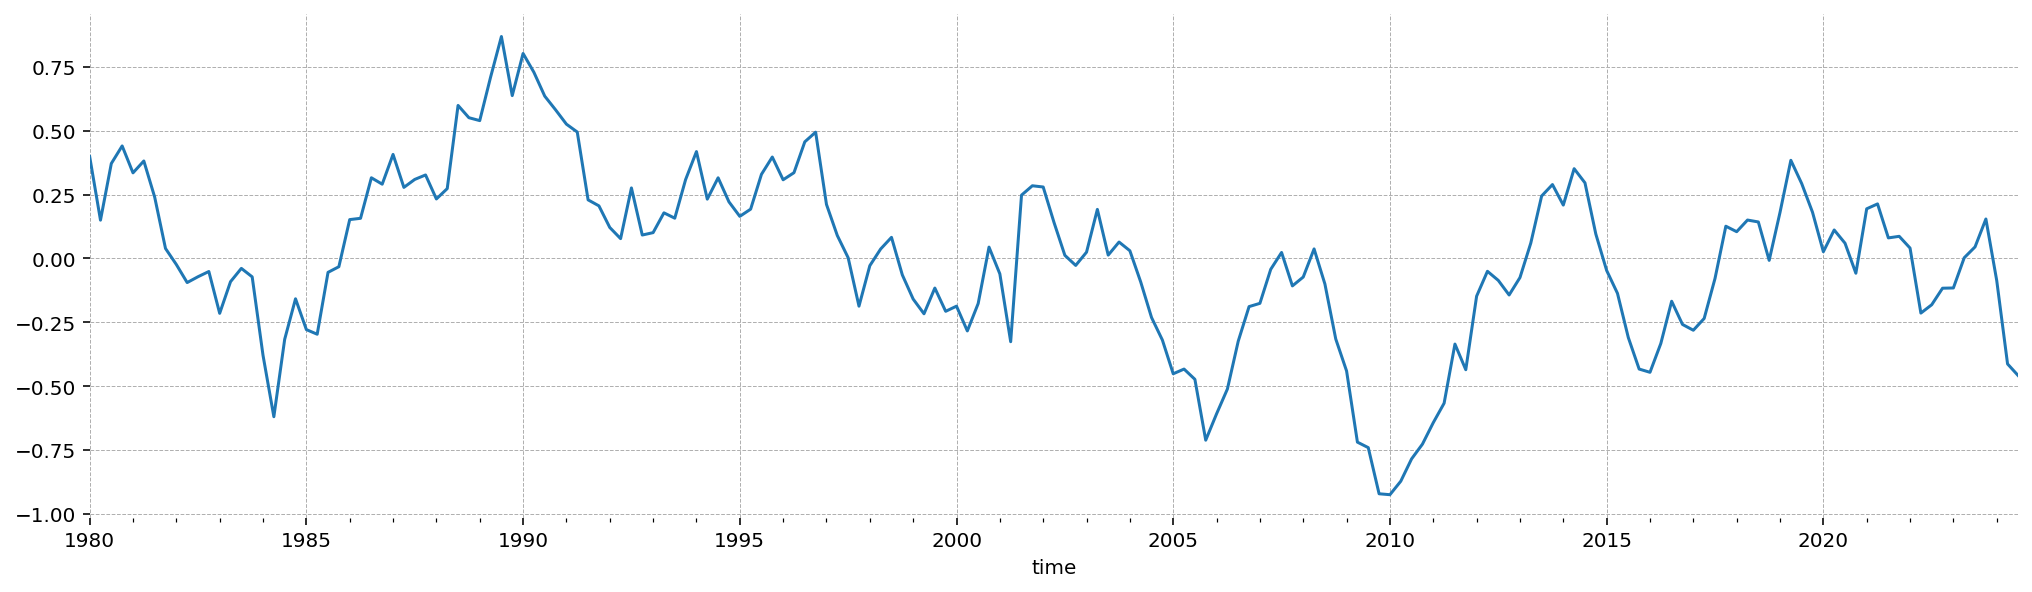

In [150]:
fake_data.plot()

## Sampling

In [81]:
with pm.Model(coords = rbc.coords) as model:
    alpha = pm.Beta('alpha', **alpha_params)
    beta = pm.Beta('beta', **beta_params)
    delta = pm.Beta('delta', **delta_params)
    rho = pm.Beta('rho', **rho_params)
    Theta = pm.TruncatedNormal('Theta', mu=1.0, sigma=1e-3, lower=0)
    sigma_C = pm.TruncatedNormal('sigma_C', mu=1.5, sigma=0.1, lower=1.01, upper=3)
    sigma_L = pm.TruncatedNormal('sigma_L', mu=2, sigma=0.1, lower=1, upper=5)
    sigma_epsilon = pm.Exponential('sigma_epsilon', lam=100)
    
    rbc.build_statespace_graph(fake_data, mode='FAST_RUN')
    
    idata = pm.sample_smc()

Initializing SMC sampler...
Sampling 5 chains in 5 jobs


Output()

/Users/jessegrabowski/mambaforge/envs/statespace/lib/python3.12/site-packages/arviz/data/base.py:265: UserWarning: More chains (5) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


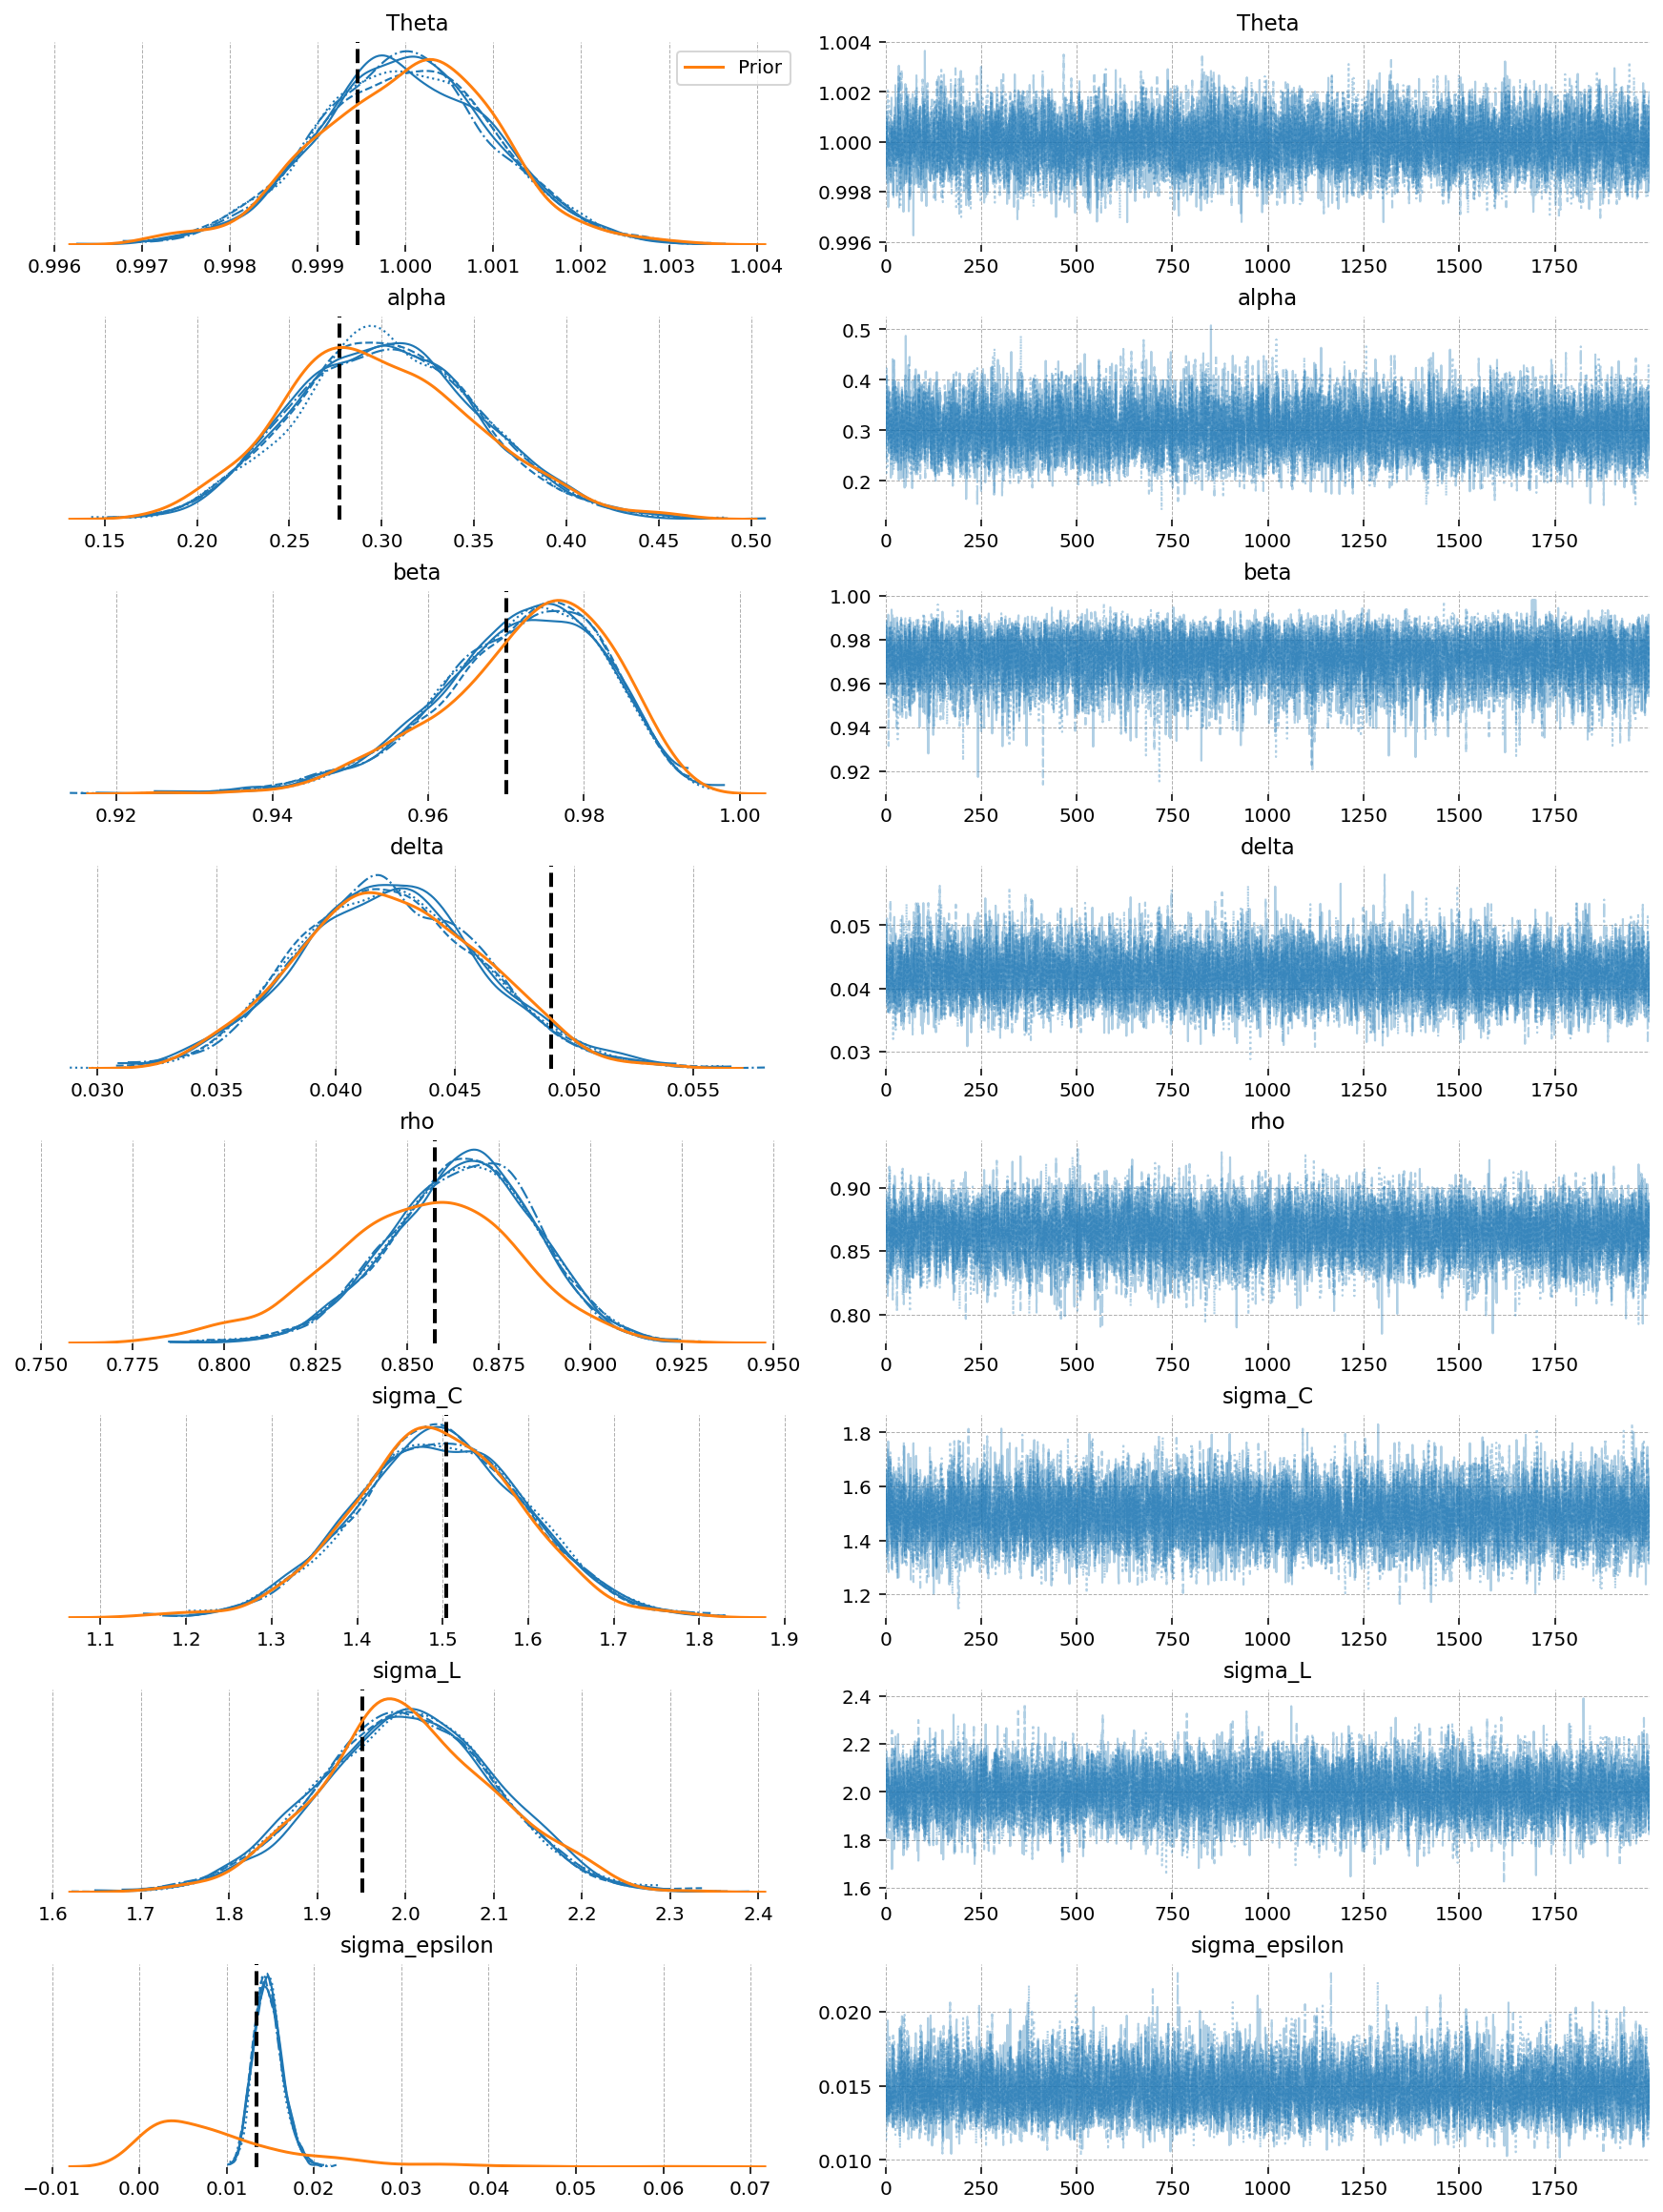

In [116]:
import seaborn as sns
axes = az.plot_trace(idata)
for i, axis in enumerate(axes[:, 0]):
    axis.axvline(true_params[i], ls='--', lw=2, c='k')
    x_grid = np.linspace(*axis.get_xlim(), 100)
    var_name = axis.get_title()
    flat_data = prior.prior[var_name].values.ravel()
    sns.kdeplot(flat_data, ax=axis, color='tab:orange', label='Prior')
    if i == 0:
        axis.legend()

## Conditional Posterior

In [117]:
idata_post = rbc.sample_conditional_posterior(idata)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

### In-sample predictions

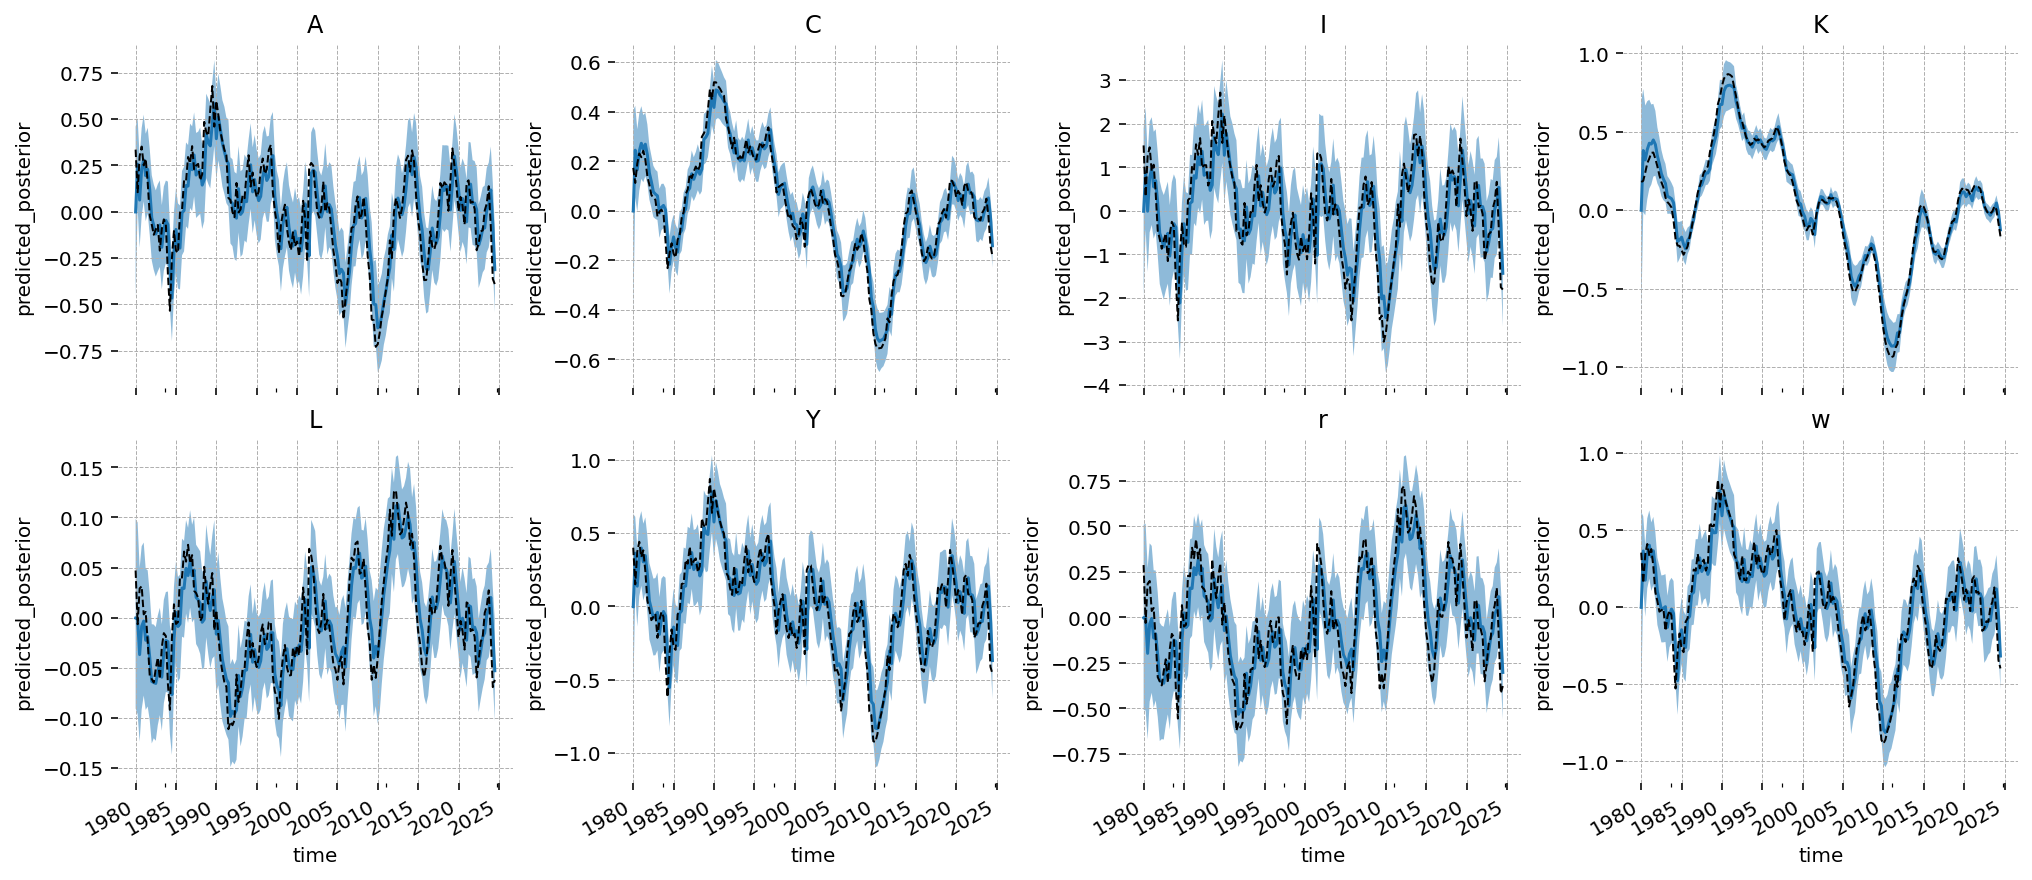

In [172]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=True)

mu = idata_post.predicted_posterior.mean(dim=['chain', 'draw'])
hdi = az.hdi(idata_post.predicted_posterior).predicted_posterior

for axis, state in zip(fig.axes, all_fake_data):
    mu.sel(state=state).plot.line(x='time', ax=axis)
    axis.fill_between(fake_data.index, *hdi.sel(state=state).values.T, alpha=0.5)
    all_fake_data[state].plot(ax=axis, color='k', lw=1, ls='--')
    axis.set(title=state)

### Kalman Smoother

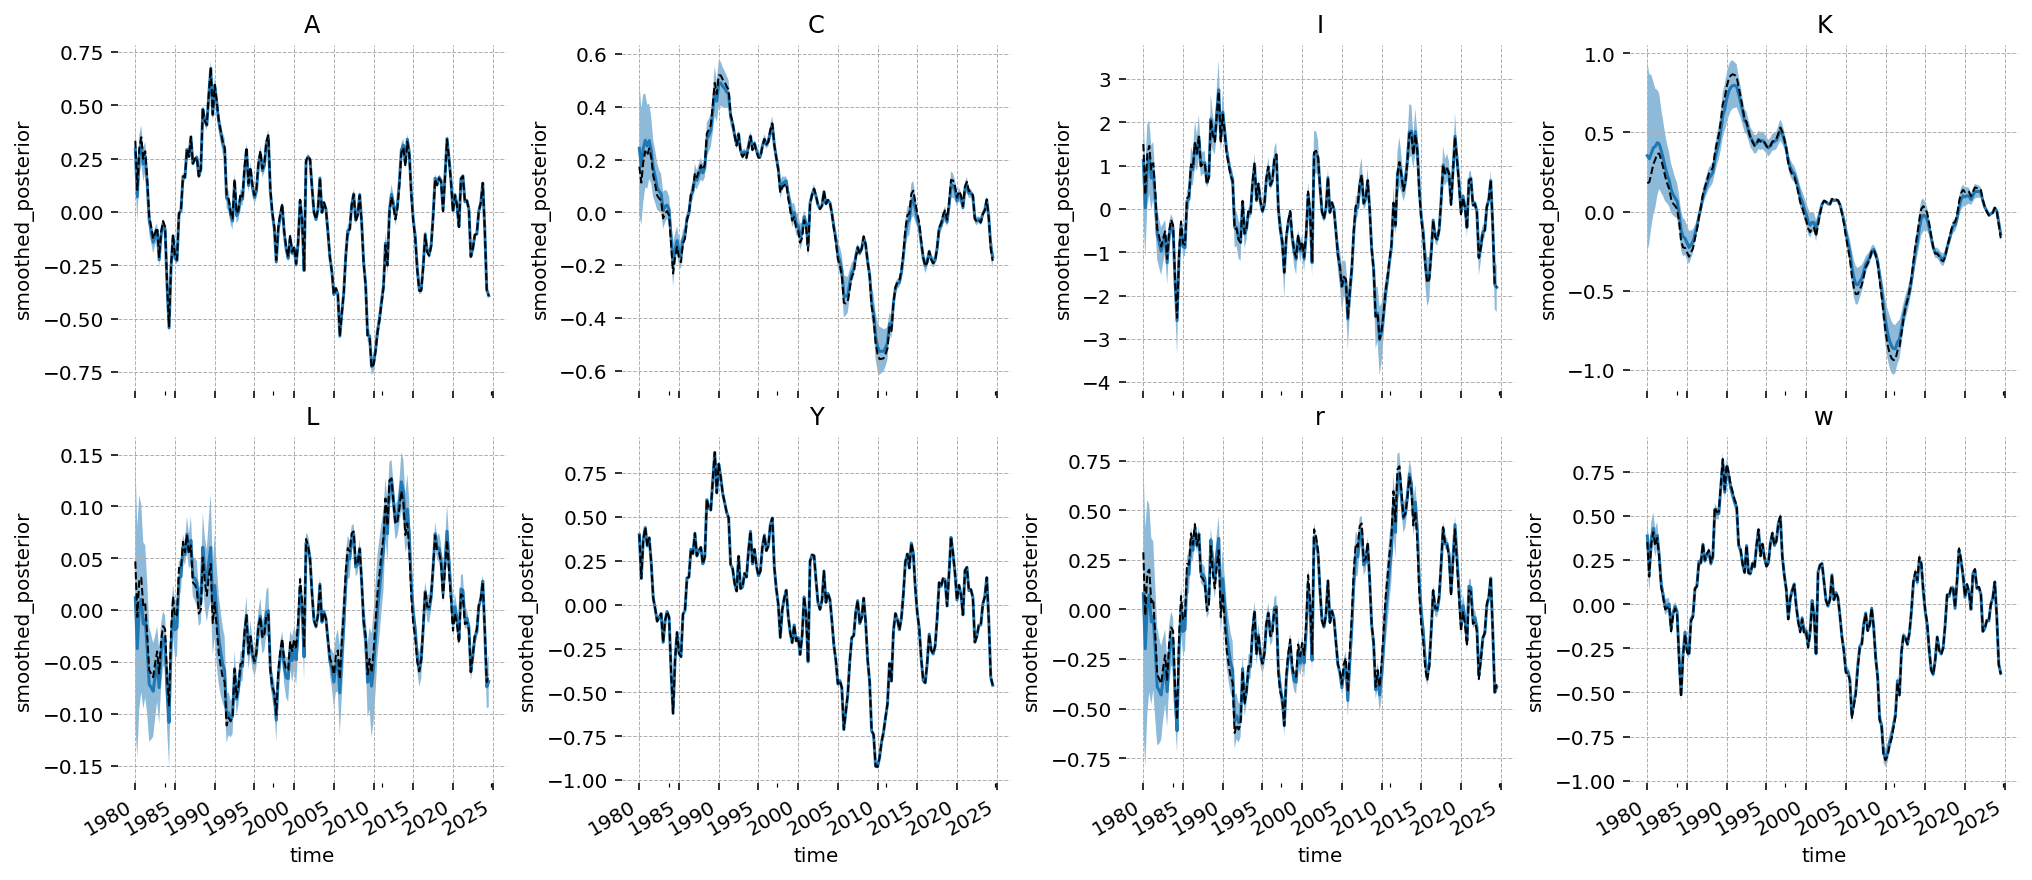

In [161]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=True)

mu = idata_post.smoothed_posterior.mean(dim=['chain', 'draw'])
hdi = az.hdi(idata_post.smoothed_posterior).smoothed_posterior

for axis, state in zip(fig.axes, all_fake_data):
    mu.sel(state=state).plot.line(x='time', ax=axis)
    axis.fill_between(fake_data.index, *hdi.sel(state=state).values.T, alpha=0.5)
    all_fake_data[state].plot(ax=axis, color='k', lw=1, ls='--')
    axis.set(title=state)

## Impulse response functions

In [162]:
irf_idata = rbc.impulse_response_function(idata, shock_size=1.0)

Sampling: []


Output()

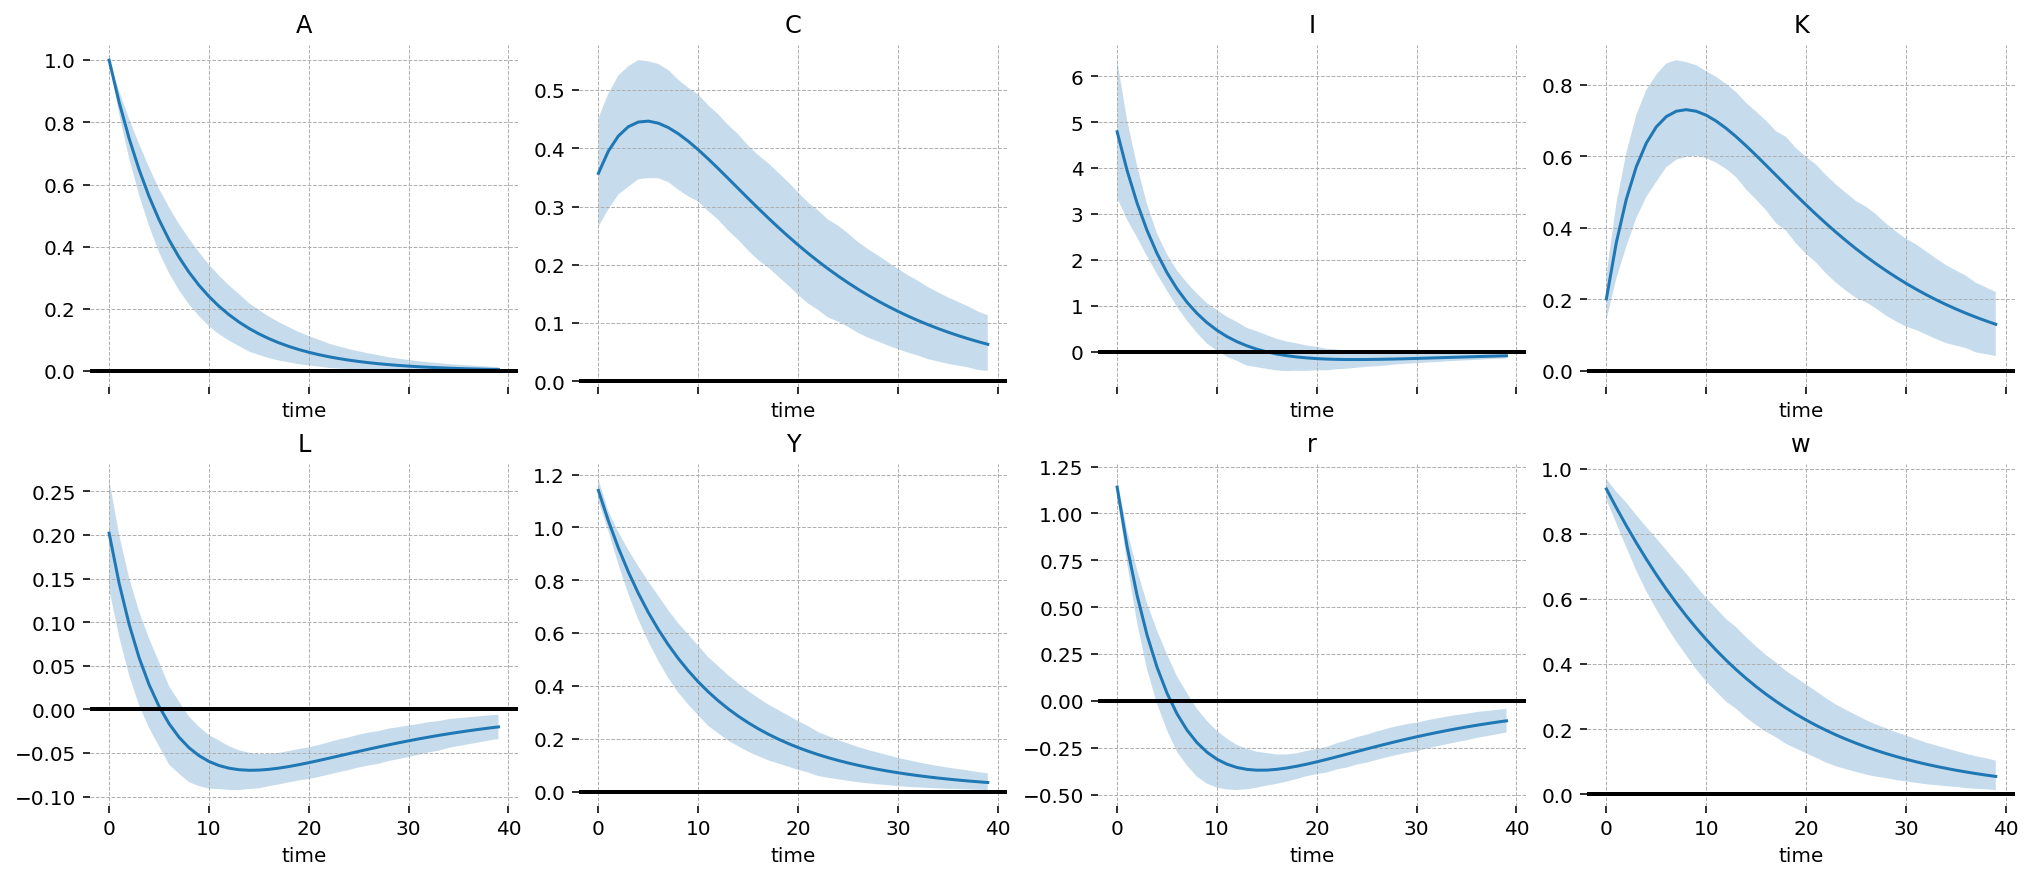

In [171]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=True)

mu = irf_idata.irf.mean(dim=['chain', 'draw'])
hdi = az.hdi(irf_idata.irf).irf

for axis, state in zip(fig.axes, all_fake_data):
    mu.sel(state=state).plot.line(x='time', ax=axis)
    axis.fill_between(mu.coords['time'], *hdi.sel(state=state).values.T, alpha=0.25)
    axis.axhline(0.0, c='k', ls='-', lw=2)
    axis.set(title=state, ylabel='')
plt.show()